<a href="https://colab.research.google.com/github/vaylerie/hyperparameter-tuning/blob/main/hp_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
import keras_tuner as kt
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.backend import clear_session

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Set directory paths
image_dir = '/content/drive/MyDrive/TugasAkhir/dataset'

# Load data into DataFrame
filename = []
label = []
# Iterate through each directory in image_dir
for dir_name in os.listdir(image_dir):
    # Iterate through each file in the directory
    for file in os.listdir(os.path.join(image_dir, dir_name)):
        # Append file path and label to lists
        filename.append(os.path.join(dir_name, file))
        label.append(dir_name)

# Create a DataFrame to hold the file paths and labels
data = {"filename": filename, "label": label}
df = pd.DataFrame(data)

# Shuffle the DataFrame
df_shuffled = df.sample(frac=1).reset_index(drop=True)
train_df = df_shuffled

# Check the total data of each class
print(train_df['label'].value_counts())

label
2nd degree    300
1st degree    300
3rd degree    300
Name: count, dtype: int64


In [ ]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare data generators
train_data_generator = train_datagen.flow_from_dataframe(
    df_shuffled,
    directory=image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    shuffle=True
)

Found 900 validated image filenames belonging to 3 classes.


In [ ]:
# Define the model
def build_model(hp):
    pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    # Freeze all layers in the pre-trained model
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = GlobalAveragePooling2D()(pretrained_model.output)

    # Tune number of dense layers and units
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        x = Dense(
            units=hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32),
            activation='relu'
        )(x)

        # Tune dropout rate
        x = Dropout(
            hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        )(x)

    # Output layer
    output = Dense(3, activation='softmax')(x)
    model = Model(pretrained_model.input, output)

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Compile the model with default hyperparameter
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
best_hyperparameters = []

# Cross-validation and training
kf = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)

# Lists to store evaluation metrics
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_F1SCORE = []

LOSS = []
ACCURACY = []

VAL_LOSS = []
VAL_ACCURACY = []

# Containers for per-fold scores
acc_per_fold = []
loss_per_fold = []

# Variable for fold iteration
fold_var = 1
Y = train_df[['label']]

In [ ]:
save_dir = '/content/drive/MyDrive/TugasAkhir/Hasil/BestHPS'
os.makedirs(save_dir, exist_ok=True)

Hyperparameter Tuning

In [ ]:
print("\nStarting Hyperparameter Tuning")

# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='accuracy',
    max_epochs=20,
    factor=3,
    directory=os.path.join(save_dir, f'tuning'),
    project_name='mobilenet_tuning'
)

# Callback
stop_early = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Search for best hyperparameters
tuner.search(
    train_data_generator,
    epochs=20,
    steps_per_epoch=train_df.shape[0] // 8,
    callbacks=[stop_early]
)

# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters Found:")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Number of dense layers: {best_hps.get('num_dense_layers')}")
for i in range(best_hps.get('num_dense_layers')):
    print(f"Dense layer {i+1} units: {best_hps.get(f'dense_{i}_units')}")
    print(f"Dropout {i+1} rate: {best_hps.get(f'dropout_{i}')}")
print("\n")

Trial 30 Complete [00h 04m 06s]
accuracy: 0.875

Best accuracy So Far: 1.0
Total elapsed time: 01h 52m 40s

Best Hyperparameters Found:
Learning rate: 0.00023763062519346705
Number of dense layers: 1
Dense layer 1 units: 320
Dropout 1 rate: 0.30000000000000004




Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 1 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 503ms/step - accuracy: 0.5022 - loss: 1.0817 - val_accuracy: 0.7889 - val_loss: 0.6509
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.7500 - loss: 0.6896

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7500 - loss: 0.6896 - val_accuracy: 0.6667 - val_loss: 0.7008
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 510ms/step - accuracy: 0.6910 - loss: 0.7308 - val_accuracy: 0.7333 - val_loss: 0.7007
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8750 - loss: 0.5453 - val_accuracy: 0.7000 - val_loss: 0.7141
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 475ms/step - accuracy: 0.7510 - loss: 0.5894 - val_accuracy: 0.6556 - val_loss: 0.7477
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 1.0000 - loss: 0.2640 - val_accuracy: 0.7222 - val_loss: 0.6657
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 79s 480ms/step - accuracy: 0.7355 - loss: 0.6113 - val_accuracy: 0.6889 - val_loss: 0.7005
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7500 - loss: 0.6346 - val_accuracy: 0.7333 - val_loss: 0.7376
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 475ms/step - accuracy: 0.7754 - loss: 0.5931 - val_accurac

Model for fold 1 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.7367 - loss: 0.8012
Score for fold 1: loss of 0.9698649644851685; compile_metrics of 66.66666865348816%
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 638ms/step


Cross Validation :  1
Accuracy :  0.6666666865348816
Precision :  0.7377777777777779
Recall :  0.6888888888888889
F1Score :  0.6987654320987654




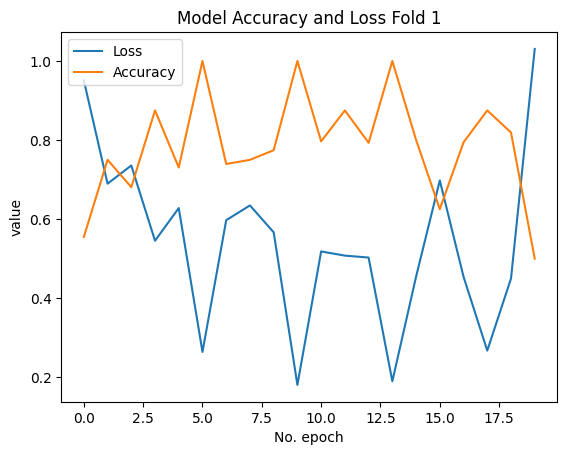

Plot for fold 1 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 1:
[[18  7  5]
 [ 5 16  9]
 [ 1  1 28]]


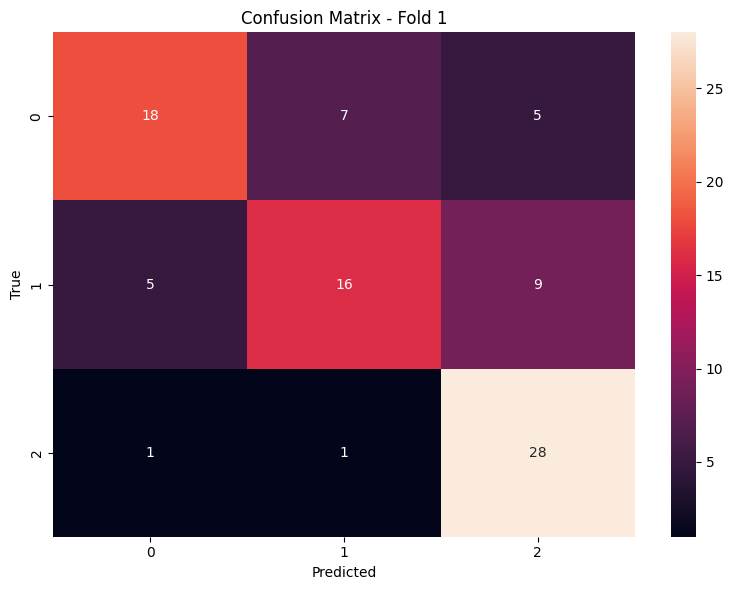

Confusion Matrix for fold 1 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 2 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 514ms/step - accuracy: 0.5158 - loss: 1.0973 - val_accuracy: 0.6556 - val_loss: 0.7561
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.6250 - loss: 0.7945

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6250 - loss: 0.7945 - val_accuracy: 0.6444 - val_loss: 0.7230
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 486ms/step - accuracy: 0.6539 - loss: 0.7337 - val_accuracy: 0.7222 - val_loss: 0.6477
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8750 - loss: 0.3483 - val_accuracy: 0.6333 - val_loss: 0.7472
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 483ms/step - accuracy: 0.7353 - loss: 0.6293 - val_accuracy: 0.6667 - val_loss: 0.7342
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6250 - loss: 0.7001 - val_accuracy: 0.7222 - val_loss: 0.6679
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 85s 551ms/step - accuracy: 0.7486 - loss: 0.5616 - val_accuracy: 0.6889 - val_loss: 0.7072
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8750 - loss: 0.2841 - val_accuracy: 0.5889 - val_loss: 0.7509
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 519ms/step - accuracy: 0.7902 - loss: 0.5033 - val_accurac

Model for fold 2 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.7063 - loss: 0.6166
Score for fold 2: loss of 0.6823610663414001; compile_metrics of 68.88889074325562%
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step


Cross Validation :  2
Accuracy :  0.6888889074325562
Precision :  0.7148148148148149
Recall :  0.7111111111111111
F1Score :  0.711374521072797




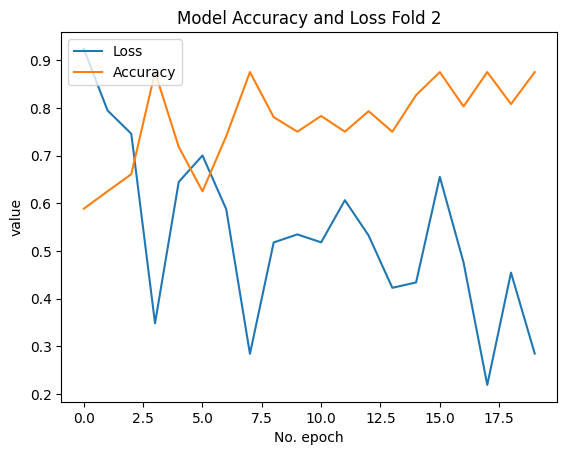

Plot for fold 2 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 2:
[[23  5  2]
 [ 9 18  3]
 [ 2  5 23]]


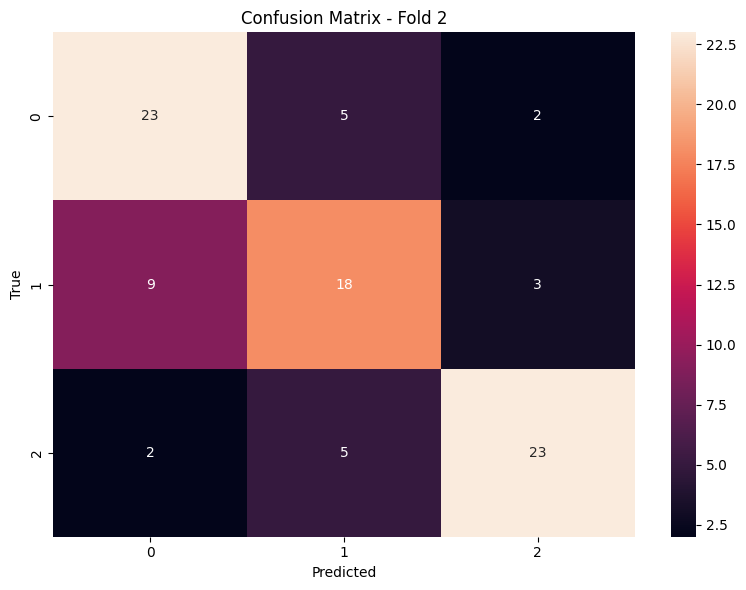

Confusion Matrix for fold 2 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 3 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 531ms/step - accuracy: 0.5367 - loss: 1.1099 - val_accuracy: 0.6667 - val_loss: 0.7663
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.5000 - loss: 0.7494

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5000 - loss: 0.7494 - val_accuracy: 0.6556 - val_loss: 0.7605
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 487ms/step - accuracy: 0.6656 - loss: 0.7228 - val_accuracy: 0.7111 - val_loss: 0.6392
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6250 - loss: 0.6900 - val_accuracy: 0.7333 - val_loss: 0.5998
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - accuracy: 0.7063 - loss: 0.6492 - val_accuracy: 0.7889 - val_loss: 0.5770
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8750 - loss: 0.4247 - val_accuracy: 0.7556 - val_loss: 0.6649
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 78s 478ms/step - accuracy: 0.7433 - loss: 0.5932 - val_accuracy: 0.7333 - val_loss: 0.6263
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8750 - loss: 0.3667 - val_accuracy: 0.7222 - val_loss: 0.6223
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 486ms/step - accuracy: 0.7558 - loss: 0.5579 - val_accurac

Model for fold 3 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.7221 - loss: 0.6451
Score for fold 3: loss of 0.6373823285102844; compile_metrics of 71.11111283302307%
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step


Cross Validation :  3
Accuracy :  0.7111111283302307
Precision :  0.7825925925925926
Recall :  0.7222222222222222
F1Score :  0.7339279078409514




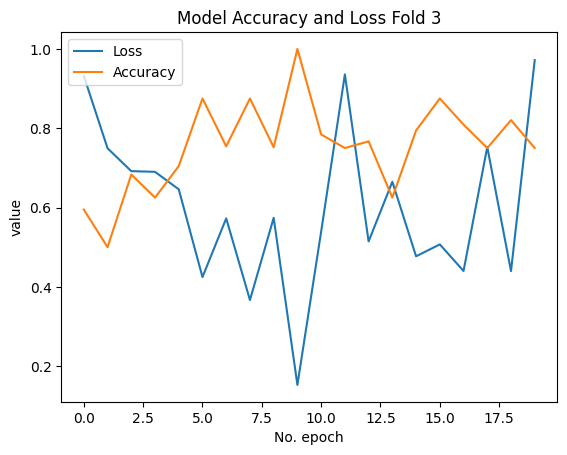

Plot for fold 3 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 3:
[[26  0  4]
 [10 14  6]
 [ 3  2 25]]


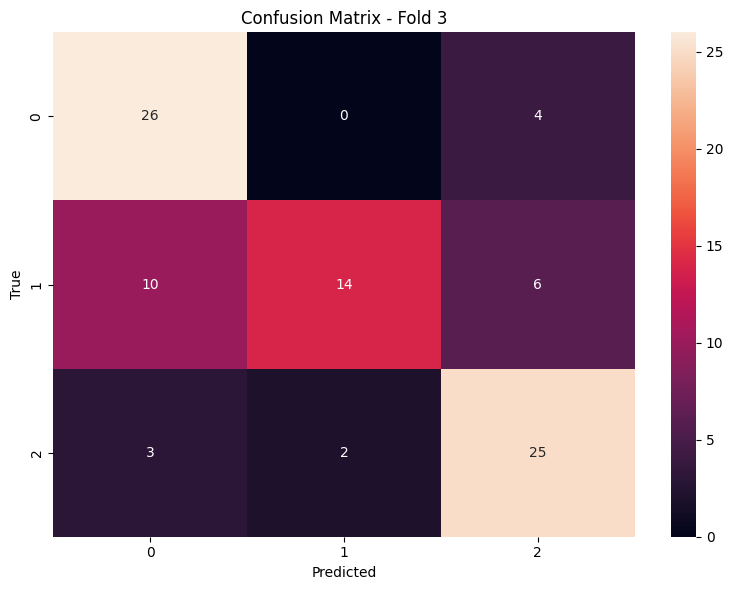

Confusion Matrix for fold 3 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 4 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 499ms/step - accuracy: 0.4904 - loss: 1.0820 - val_accuracy: 0.6778 - val_loss: 0.7386
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.7500 - loss: 0.5577

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7500 - loss: 0.5577 - val_accuracy: 0.6889 - val_loss: 0.7091
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 486ms/step - accuracy: 0.6834 - loss: 0.6741 - val_accuracy: 0.7000 - val_loss: 0.7271
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7500 - loss: 0.6215 - val_accuracy: 0.7111 - val_loss: 0.6863
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 78s 506ms/step - accuracy: 0.7280 - loss: 0.6251 - val_accuracy: 0.7111 - val_loss: 0.6651
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7500 - loss: 0.5746 - val_accuracy: 0.6889 - val_loss: 0.6578
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 476ms/step - accuracy: 0.7468 - loss: 0.5657 - val_accuracy: 0.7667 - val_loss: 0.6388
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7500 - loss: 0.5173 - val_accuracy: 0.7111 - val_loss: 0.6386
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 525ms/step - accuracy: 0.7576 - loss: 0.5721 - val_accurac

Model for fold 4 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.7515 - loss: 0.7181
Score for fold 4: loss of 0.7431022524833679; compile_metrics of 74.44444298744202%
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 585ms/step


Cross Validation :  4
Accuracy :  0.7444444298744202
Precision :  0.7448148148148148
Recall :  0.6888888888888889
F1Score :  0.6998885172798216




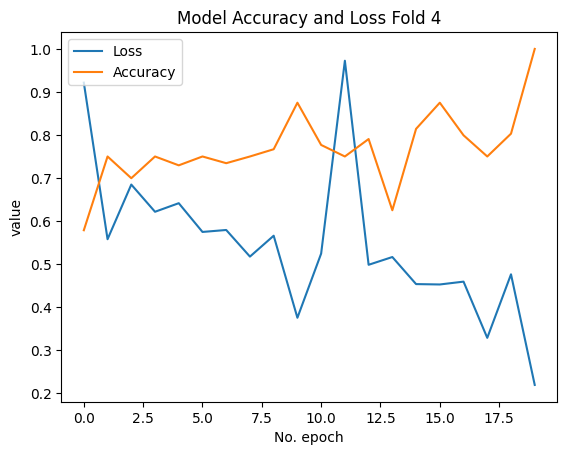

Plot for fold 4 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 4:
[[13 15  2]
 [ 2 22  6]
 [ 1  2 27]]


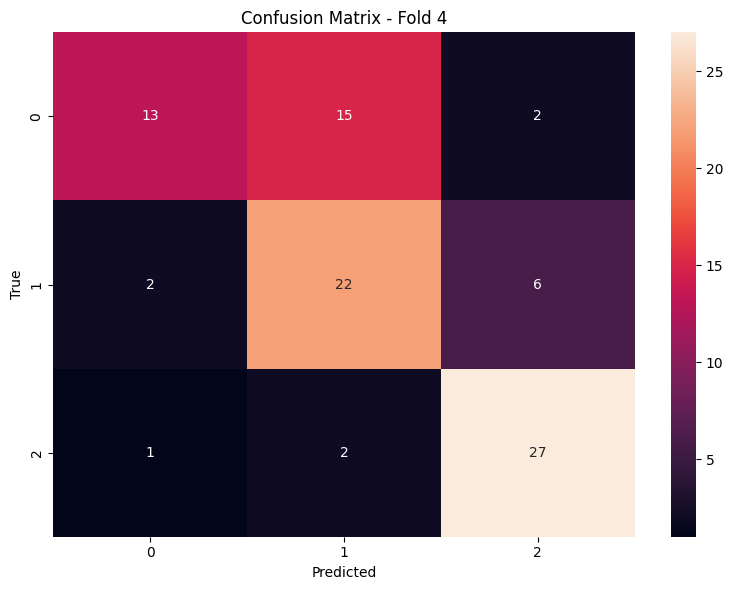

Confusion Matrix for fold 4 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 5 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 529ms/step - accuracy: 0.4907 - loss: 1.0994 - val_accuracy: 0.6333 - val_loss: 0.8020
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.8750 - loss: 0.3805

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8750 - loss: 0.3805 - val_accuracy: 0.7111 - val_loss: 0.6856
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 485ms/step - accuracy: 0.6729 - loss: 0.6929 - val_accuracy: 0.7778 - val_loss: 0.5784
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7500 - loss: 0.5305 - val_accuracy: 0.7333 - val_loss: 0.6327
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 479ms/step - accuracy: 0.7313 - loss: 0.6451 - val_accuracy: 0.7222 - val_loss: 0.6139
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8750 - loss: 0.4255 - val_accuracy: 0.7333 - val_loss: 0.5533
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 537ms/step - accuracy: 0.7081 - loss: 0.6387 - val_accuracy: 0.7111 - val_loss: 0.6553
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7500 - loss: 0.3511 - val_accuracy: 0.7333 - val_loss: 0.5835
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 71s 483ms/step - accuracy: 0.7695 - loss: 0.5322 - val_accurac

Model for fold 5 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.8052 - loss: 0.4881
Score for fold 5: loss of 0.5597609281539917; compile_metrics of 75.55555701255798%
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 627ms/step


Cross Validation :  5
Accuracy :  0.7555555701255798
Precision :  0.8207407407407408
Recall :  0.8222222222222222
F1Score :  0.8210037057973746




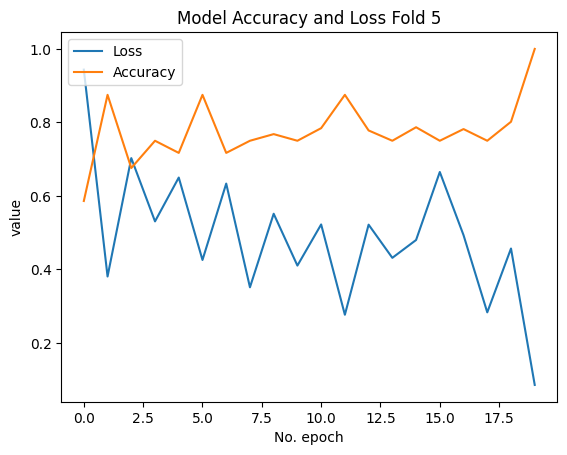

Plot for fold 5 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 5:
[[25  4  1]
 [ 6 23  1]
 [ 0  4 26]]


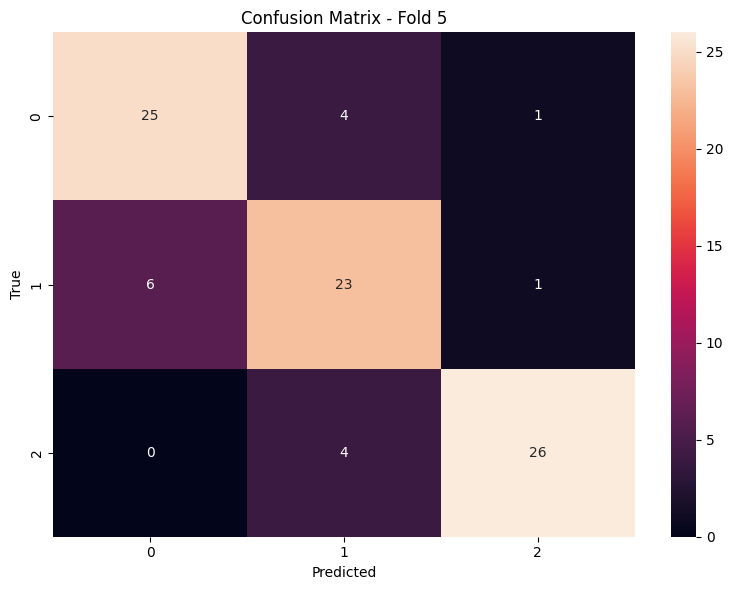

Confusion Matrix for fold 5 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 6 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.4425 - loss: 1.2149 - val_accuracy: 0.6222 - val_loss: 0.7486
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 41s 418ms/step - accuracy: 0.6250 - loss: 0.5493

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6250 - loss: 0.5493 - val_accuracy: 0.7111 - val_loss: 0.7142
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 501ms/step - accuracy: 0.6250 - loss: 0.7893 - val_accuracy: 0.7333 - val_loss: 0.6664
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6250 - loss: 0.8687 - val_accuracy: 0.7111 - val_loss: 0.6122
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 74s 472ms/step - accuracy: 0.7142 - loss: 0.7146 - val_accuracy: 0.6667 - val_loss: 0.6925
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8750 - loss: 0.2840 - val_accuracy: 0.7000 - val_loss: 0.7604
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 471ms/step - accuracy: 0.7654 - loss: 0.5498 - val_accuracy: 0.7111 - val_loss: 0.6185
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.5000 - loss: 0.9024 - val_accuracy: 0.6556 - val_loss: 0.6672
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 74s 492ms/step - accuracy: 0.7491 - loss: 0.5943 - val_accur

Model for fold 6 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 553ms/step - accuracy: 0.6397 - loss: 0.6943
Score for fold 6: loss of 0.6884698867797852; compile_metrics of 64.4444465637207%
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step


Cross Validation :  6
Accuracy :  0.644444465637207
Precision :  0.7362962962962963
Recall :  0.7333333333333333
F1Score :  0.7338324658817854




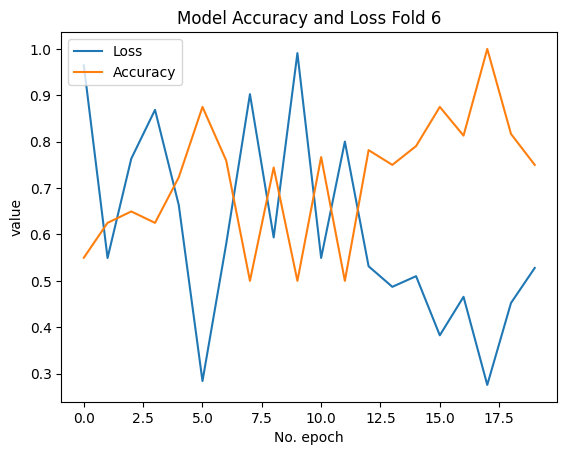

Plot for fold 6 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 6:
[[21  9  0]
 [ 5 19  6]
 [ 1  3 26]]


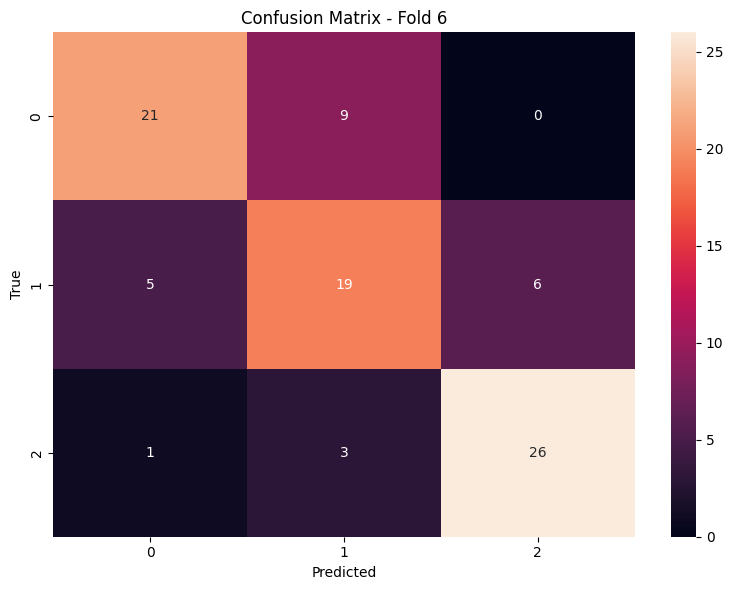

Confusion Matrix for fold 6 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 7 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 56s 492ms/step - accuracy: 0.4836 - loss: 1.1243 - val_accuracy: 0.6333 - val_loss: 0.7312
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.6250 - loss: 0.7181

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6250 - loss: 0.7181 - val_accuracy: 0.6556 - val_loss: 0.7407
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 74s 480ms/step - accuracy: 0.6877 - loss: 0.6918 - val_accuracy: 0.6778 - val_loss: 0.6705
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.6250 - loss: 0.7278 - val_accuracy: 0.6333 - val_loss: 0.7693
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 470ms/step - accuracy: 0.7083 - loss: 0.6471 - val_accuracy: 0.7000 - val_loss: 0.6809
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5000 - loss: 1.4082 - val_accuracy: 0.7111 - val_loss: 0.7529
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 460ms/step - accuracy: 0.7314 - loss: 0.5857 - val_accuracy: 0.6556 - val_loss: 0.7530
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6250 - loss: 0.5873 - val_accuracy: 0.6778 - val_loss: 0.6880
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 466ms/step - accuracy: 0.7837 - loss: 0.5325 - val_accur

Model for fold 7 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.6610 - loss: 0.6146
Score for fold 7: loss of 0.6798282861709595; compile_metrics of 65.55555462837219%
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 841ms/step


Cross Validation :  7
Accuracy :  0.6555555462837219
Precision :  0.6881481481481481
Recall :  0.6888888888888889
F1Score :  0.6832716517850171




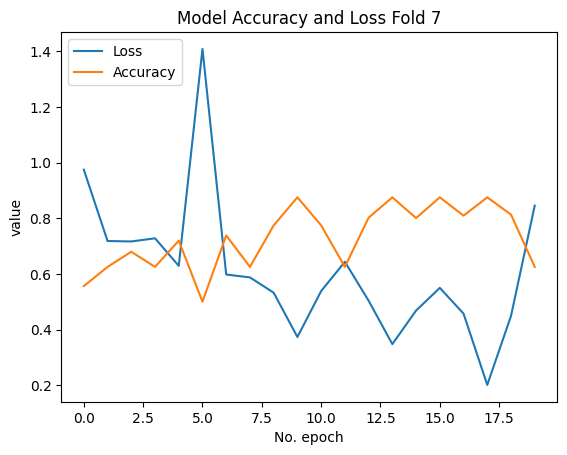

Plot for fold 7 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 7:
[[22  8  0]
 [ 6 20  4]
 [ 1  9 20]]


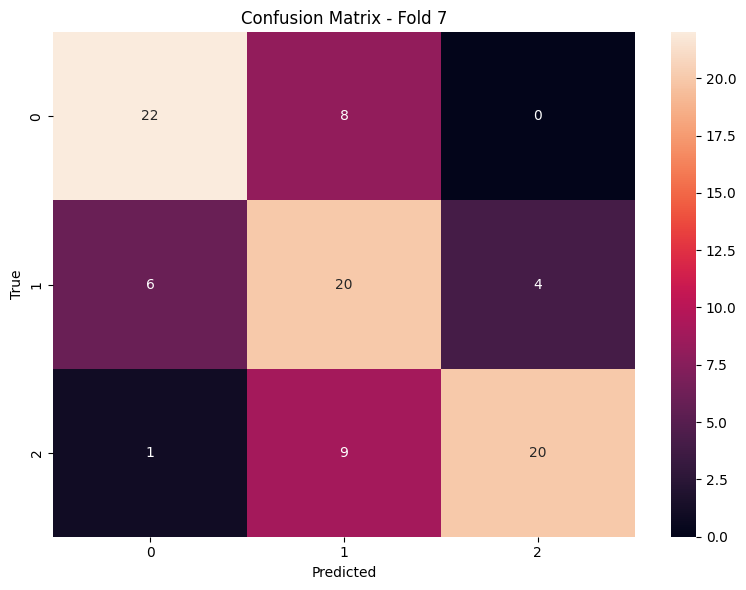

Confusion Matrix for fold 7 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 8 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 499ms/step - accuracy: 0.5008 - loss: 1.1401 - val_accuracy: 0.6333 - val_loss: 0.8317
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.7500 - loss: 0.6642

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7500 - loss: 0.6642 - val_accuracy: 0.6778 - val_loss: 0.7835
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 80s 531ms/step - accuracy: 0.7022 - loss: 0.6961 - val_accuracy: 0.6778 - val_loss: 0.7661
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7500 - loss: 0.6237 - val_accuracy: 0.6778 - val_loss: 0.7467
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 490ms/step - accuracy: 0.7305 - loss: 0.5992 - val_accuracy: 0.6222 - val_loss: 0.8396
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5000 - loss: 0.9042 - val_accuracy: 0.7444 - val_loss: 0.7094
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 78s 505ms/step - accuracy: 0.7627 - loss: 0.5875 - val_accuracy: 0.6889 - val_loss: 0.8014
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2500 - loss: 0.8996 - val_accuracy: 0.7111 - val_loss: 0.7492
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 75s 493ms/step - accuracy: 0.7934 - loss: 0.5420 - val_accurac

Model for fold 8 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - accuracy: 0.7654 - loss: 0.7295
Score for fold 8: loss of 0.6718243956565857; compile_metrics of 75.55555701255798%
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 550ms/step


Cross Validation :  8
Accuracy :  0.7555555701255798
Precision :  0.7603703703703704
Recall :  0.7
F1Score :  0.714015535292131




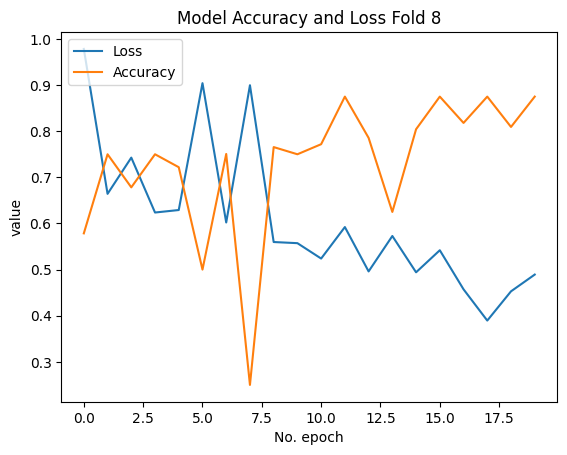

Plot for fold 8 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 8:
[[26  2  2]
 [10 13  7]
 [ 4  2 24]]


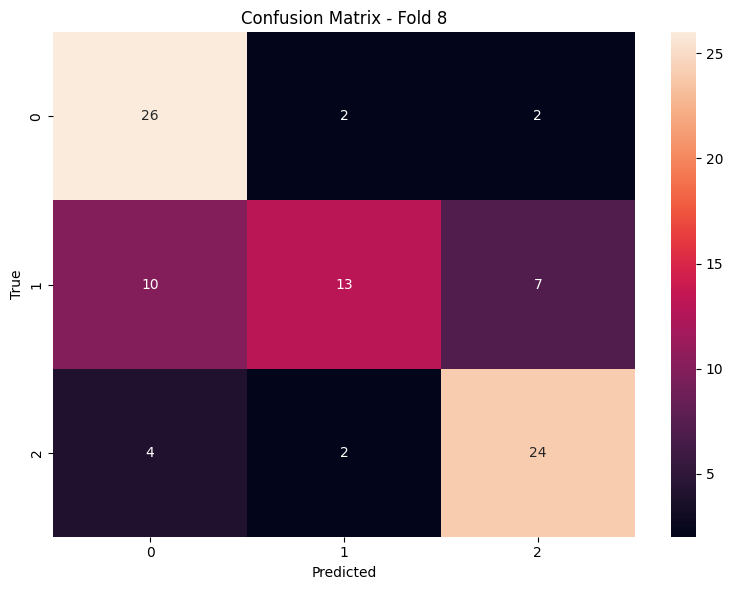

Confusion Matrix for fold 8 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 9 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 62s 535ms/step - accuracy: 0.4779 - loss: 1.1315 - val_accuracy: 0.6556 - val_loss: 0.7566
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.7500 - loss: 0.8943

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7500 - loss: 0.8943 - val_accuracy: 0.6667 - val_loss: 0.7527
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 491ms/step - accuracy: 0.6984 - loss: 0.7402 - val_accuracy: 0.6222 - val_loss: 0.8316
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7500 - loss: 0.5908 - val_accuracy: 0.6889 - val_loss: 0.7574
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 490ms/step - accuracy: 0.6859 - loss: 0.7170 - val_accuracy: 0.6333 - val_loss: 0.7964
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5000 - loss: 0.8304 - val_accuracy: 0.6444 - val_loss: 0.7357
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 75s 494ms/step - accuracy: 0.7361 - loss: 0.6099 - val_accuracy: 0.6667 - val_loss: 0.7266
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7500 - loss: 0.8171 - val_accuracy: 0.7000 - val_loss: 0.6615
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 79s 500ms/step - accuracy: 0.7396 - loss: 0.5795 - val_accurac

Model for fold 9 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.7265 - loss: 0.6287
Score for fold 9: loss of 0.6693764925003052; compile_metrics of 71.11111283302307%
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step


Cross Validation :  9
Accuracy :  0.7111111283302307
Precision :  0.752962962962963
Recall :  0.7444444444444445
F1Score :  0.745628194780737




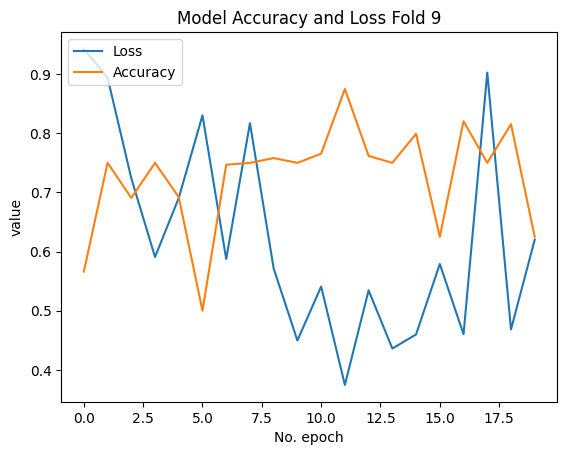

Plot for fold 9 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 9:
[[26  3  1]
 [ 8 19  3]
 [ 1  7 22]]


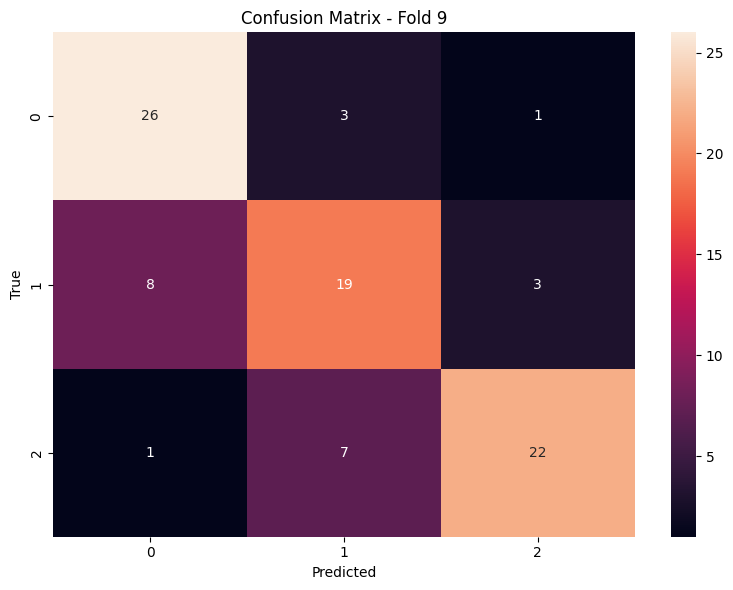

Confusion Matrix for fold 9 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


Found 810 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.

Training fold 10 ...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.4919 - loss: 1.0605 - val_accuracy: 0.6778 - val_loss: 0.7083
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 48s 486ms/step - accuracy: 0.6250 - loss: 0.7669

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6250 - loss: 0.7669 - val_accuracy: 0.6000 - val_loss: 0.7303
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 73s 480ms/step - accuracy: 0.6679 - loss: 0.7300 - val_accuracy: 0.6556 - val_loss: 0.7371
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6250 - loss: 0.8431 - val_accuracy: 0.5889 - val_loss: 0.6878
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 496ms/step - accuracy: 0.7270 - loss: 0.6052 - val_accuracy: 0.6778 - val_loss: 0.6910
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7500 - loss: 0.5677 - val_accuracy: 0.5778 - val_loss: 0.7564
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 75s 484ms/step - accuracy: 0.7666 - loss: 0.5702 - val_accuracy: 0.6889 - val_loss: 0.6409
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8750 - loss: 0.3140 - val_accuracy: 0.7111 - val_loss: 0.6665
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 526ms/step - accuracy: 0.7820 - loss: 0.5301 - val_accurac

Model for fold 10 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.7230 - loss: 0.5648
Score for fold 10: loss of 0.5714383125305176; compile_metrics of 71.11111283302307%
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 486ms/step


Cross Validation :  10
Accuracy :  0.7111111283302307
Precision :  0.7374074074074075
Recall :  0.7333333333333333
F1Score :  0.7343587555159735




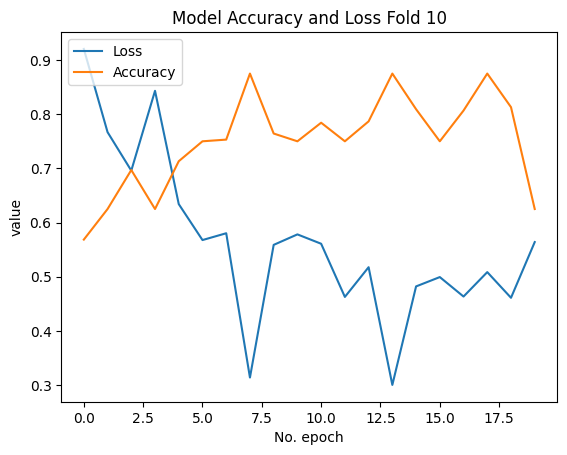

Plot for fold 10 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Confusion Matrix for Fold 10:
[[23  7  0]
 [ 4 18  8]
 [ 1  4 25]]


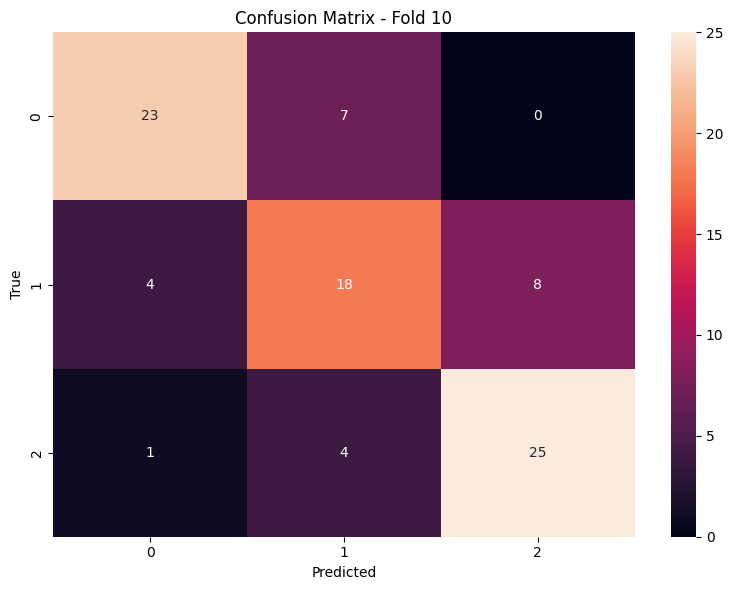

Confusion Matrix for fold 10 saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.



Cross-validation Finished


In [ ]:
# Perform k-fold cross-validation
for train_index, val_index in kf.split(np.zeros(len(Y)), Y):
    training_data = train_df.iloc[train_index]
    validation_data = train_df.iloc[val_index]

    # Create data generators for training and validation
    train_data_generator = train_datagen.flow_from_dataframe(
        training_data,
        directory=image_dir,
        x_col="filename",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        class_mode="categorical",
        shuffle=True
    )

    valid_data_generator = train_datagen.flow_from_dataframe(
        validation_data,
        directory=image_dir,
        x_col="filename",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        class_mode="categorical",
        shuffle=False
    )

    print(f'\nTraining fold {fold_var} ...')

    # Build model with best hyperparameters
    model = tuner.hypermodel.build(best_hps)

    # Train best model
    history =model.fit(
        train_data_generator,
        validation_data=valid_data_generator,
        epochs=20,
        steps_per_epoch=training_data.shape[0] // 8
    )

    # Save the model
    model.save(os.path.join(save_dir, f"model_fold_{fold_var}.h5"))
    print(f"Model for fold {fold_var} saved to {save_dir}.")
    print('\n')

    # Evaluate the model on validation data
    results = model.evaluate(valid_data_generator)
    print(f'Score for fold {fold_var}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1] * 100}%')

    # Predict labels for validation data
    y_predict = model.predict(valid_data_generator)
    y = np.asarray(valid_data_generator.labels)
    y_predict_labels = np.argmax(y_predict, axis=1)

    # Calculate evaluation metrics
    acc = accuracy_score(y_predict_labels, y)
    prec = precision_score(y_predict_labels, y, average='weighted')
    rec = recall_score(y_predict_labels, y, average='weighted')
    f1score = f1_score(y_predict_labels, y, average='weighted')

    print("\n")
    print("Cross Validation : ", fold_var)
    print("Accuracy : ", results[1])
    print("Precision : ", prec)
    print("Recall : ", rec)
    print("F1Score : ", f1score)
    print("\n")

    # Plot training history
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title(f'Model Accuracy and Loss Fold {fold_var}')
    plt.ylabel('value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.savefig(os.path.join(save_dir, f'plot_fold_{fold_var}.png'))
    plt.show()
    print(f"Plot for fold {fold_var} saved to {save_dir}.")
    print('\n')

    # Append metrics to lists
    VALIDATION_ACCURACY.append(results[1])
    VALIDATION_PRECISION.append(prec)
    VALIDATION_RECALL.append(rec)
    VALIDATION_F1SCORE.append(f1score)

    LOSS.append(history.history['loss'])
    ACCURACY.append(history.history['accuracy'])

    VAL_LOSS.append(history.history['val_loss'])
    VAL_ACCURACY.append(history.history['val_accuracy'])

    acc_per_fold.append(results[1] * 100)
    loss_per_fold.append(results[0])

    # Display confusion matrix for validation set
    print(f"\nConfusion Matrix for Fold {fold_var}:")
    print(confusion_matrix(y, y_predict_labels))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y, y_predict_labels), annot=True, fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Fold {fold_var}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'confusion_matrix_fold_{fold_var}.png'))
    plt.show()
    print(f"Confusion Matrix for fold {fold_var} saved to {save_dir}.")
    print('\n')

    fold_var += 1

print("\nCross-validation Finished")

In [ ]:
print(VALIDATION_ACCURACY)
print(VALIDATION_PRECISION)
print(VALIDATION_RECALL)
print(VALIDATION_F1SCORE)

[0.6666666865348816, 0.6888889074325562, 0.7111111283302307, 0.7444444298744202, 0.7555555701255798, 0.644444465637207, 0.6555555462837219, 0.7555555701255798, 0.7111111283302307, 0.7111111283302307]
[0.7377777777777779, 0.7148148148148149, 0.7825925925925926, 0.7448148148148148, 0.8207407407407408, 0.7362962962962963, 0.6881481481481481, 0.7603703703703704, 0.752962962962963, 0.7374074074074075]
[0.6888888888888889, 0.7111111111111111, 0.7222222222222222, 0.6888888888888889, 0.8222222222222222, 0.7333333333333333, 0.6888888888888889, 0.7, 0.7444444444444445, 0.7333333333333333]
[0.6987654320987654, 0.711374521072797, 0.7339279078409514, 0.6998885172798216, 0.8210037057973746, 0.7338324658817854, 0.6832716517850171, 0.714015535292131, 0.745628194780737, 0.7343587555159735]


In [ ]:
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} ')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9698649644851685 - Accuracy: 66.66666865348816%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6823610663414001 - Accuracy: 68.88889074325562%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6373823285102844 - Accuracy: 71.11111283302307%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.7431022524833679 - Accuracy: 74.44444298744202%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5597609281539917 - Accuracy: 75.55555701255798%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.6884698867797852 - Accuracy: 64.4444465637207%
------------------------------------------------------------------------


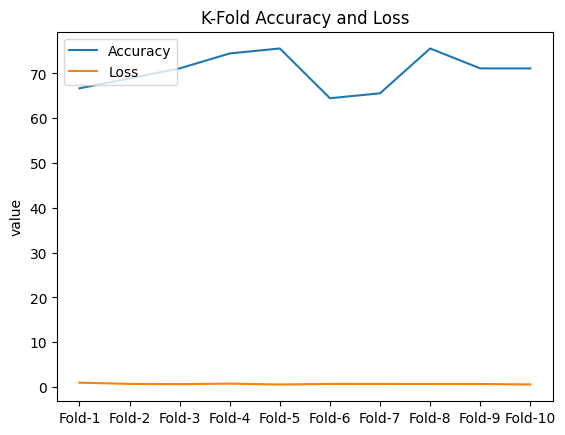

K-Fold Accuracy and Loss Plot saved to /content/drive/MyDrive/TugasAkhir/Hasil/BestHPS.




In [ ]:
# Plotting K-Fold Accuracy and Loss
plt.plot(acc_per_fold, label='Accuracy')
plt.plot(loss_per_fold, label='Loss')
plt.title('K-Fold Accuracy and Loss')
plt.ylabel('value')
x = ["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5", "Fold-6", "Fold-7", "Fold-8", "Fold-9", "Fold-10"]

default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.legend(loc="upper left")
plt.savefig(os.path.join(save_dir, f'K_fold_accuracy_loss_plot.png'))
plt.show()
print(f"K-Fold Accuracy and Loss Plot saved to {save_dir}.")
print('\n')

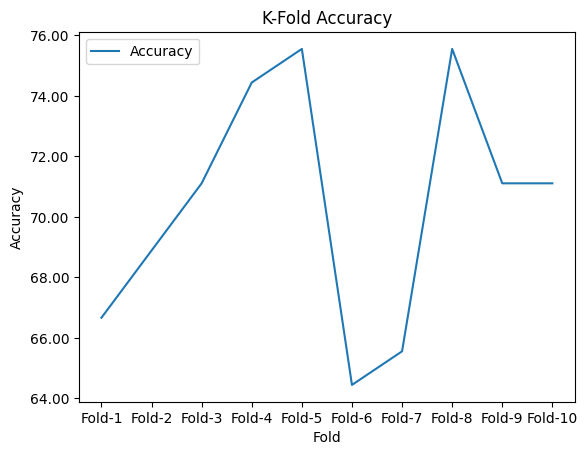

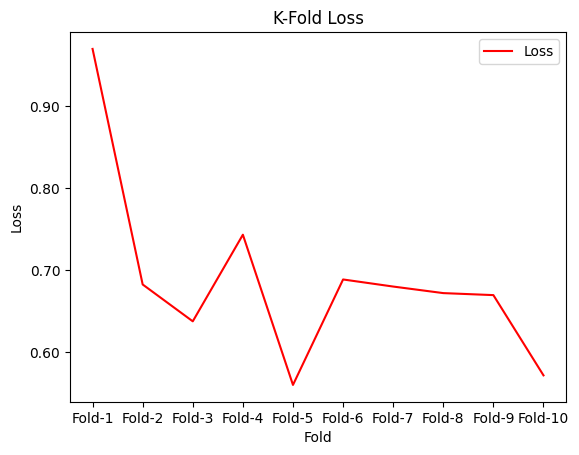

In [ ]:
# Plotting Accuracy for each fold
plt.plot(acc_per_fold, label='Accuracy')
plt.title('K-Fold Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.xticks(default_x_ticks, x)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.legend()
plt.savefig(os.path.join(save_dir, 'kfold_accuracy_plot.png'))
plt.show()

# Plotting Loss for each fold
plt.plot(loss_per_fold, label='Loss', color='red')
plt.title('K-Fold Loss')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.xticks(default_x_ticks, x)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.legend()
plt.savefig(os.path.join(save_dir, 'kfold_loss_plot.png'))
plt.show()